# Youtube API data analysis - MrBeast Channel

## Getting Data from API

In [1]:
# Import required packages
from googleapiclient.discovery import build
from dateutil import parser
import pandas as pd
from IPython.display import JSON

# Data viz packages
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kedarnadh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kedarnadh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
#API key
api_key = 'YOUR_YOUTUBE_API_KEY'

In [3]:
channel_ids = ['UCX6OQ3DkcsbYNE6H8uQQuVA'] #we can add more channels to the list

In [4]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey=api_key)

In [5]:
# Funciton to get channel statistics
def get_channel_stats(youtube, channel_ids):
    
    all_data = []
    
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_ids)
    )
    response = request.execute()

    # loop through items
    for item in response['items']:
        data = {'channelName': item['snippet']['title'],
                'subscribers': item['statistics']['subscriberCount'],
                'views': item['statistics']['viewCount'],
                'totalVideos': item['statistics']['videoCount'],
                'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
        }
        
        all_data.append(data)
        
    return pd.DataFrame(all_data)


In [6]:
channel_stats = get_channel_stats(youtube, channel_ids)
channel_stats

,channelName,subscribers,views,totalVideos,playlistId
0,MrBeast,309000000,56477377821,809,UUX6OQ3DkcsbYNE6H8uQQuVA


In [7]:
playlist_id = "UUX6OQ3DkcsbYNE6H8uQQuVA"

In [8]:
# Funciton to get video ids
def get_video_ids(youtube, playlist_id):
    
    video_ids = []
    
    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults = 50
    )
    response = request.execute()
    
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
                    part='contentDetails',
                    playlistId = playlist_id,
                    maxResults = 50,
                    pageToken = next_page_token)
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')
        
    return video_ids

In [9]:
# Get video IDs
video_ids = get_video_ids(youtube, playlist_id)

In [10]:
len(video_ids)


809

In [11]:
# Funciton to get video details
def get_video_details(youtube, video_ids):

    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
    
    return pd.DataFrame(all_video_info)

In [12]:
# Get video details
video_df = get_video_details(youtube, video_ids)
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,UPrkC1LdlLY,MrBeast,"Survive 100 Days In Nuclear Bunker, Win $500,000","This video was really fun to make, I hope you ...",None,2024-08-03T16:00:00Z,135332103,4568329,None,85730,PT32M21S,hd,true
1,8bTQMDM4qvY,MrBeast,"Spot The Fake Animal For $10,000",,None,2024-07-19T16:00:00Z,202789285,9382611,None,23043,PT40S,hd,false
2,4SNThp0YiU4,MrBeast,"50 YouTubers Fight For $1,000,000",I can’t believe how intense this video got\nTh...,None,2024-07-13T16:00:01Z,220573071,8345750,None,378342,PT41M27S,hd,true
3,XhuisK0bTSA,MrBeast,Pass The Phone To…,,None,2024-07-11T17:00:01Z,98416761,6833703,None,41866,PT1M,hd,false
4,lkCRPp7cnP8,MrBeast,How Many Balloons Does It Take To Fly?,,None,2024-07-10T17:00:00Z,218125156,11925139,None,46817,PT18S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,7qj3nuF9Dzw,MrBeast,Most Epic minecraft skin EVER (Psy),Psy in minecraft!!! drop a like for psy's mo...,"[psy, minecraft, epic, skin, most, ever]",2013-01-13T01:59:21Z,1044978,40002,None,3683,PT31S,hd,false
805,Y74b7WlcEpk,MrBeast,More birds IN MINECRAFT!!,Basically what this mod does is adds more bird...,"[birds, minecraft, in, more, must, see, epic]",2013-01-12T23:35:45Z,1188673,45264,None,3879,PT2M6S,hd,false
806,Z8nEEdXTaX0,MrBeast,Boxy item mod Minecraft. EPIC,At the begining i said i was mrbeast6000.... i...,"[boxy, item, mod, minecraft, epic]",2013-01-12T22:34:11Z,1400574,53385,None,4420,PT1M30S,hd,false
807,jP82d277Cc8,MrBeast,Harry Potter Mod In Minecraft! EPIC MUST SEE M...,One of the coolest mods i have ever seen\n\nMo...,"[Harry Potter minecraft, minecraft, minecraft ...",2012-03-09T23:29:03Z,5150734,None,None,9627,PT3M59S,hd,false


## Data pre-processing


In [13]:
# Check for NULL values
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount         False
likeCount          True
favouriteCount     True
commentCount       True
duration          False
definition        False
caption           False
dtype: bool

In [14]:
# Check data types
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [15]:
# Convert count columns to numeric
numeric_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

In [16]:
# Publish day in the week
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x)) 
video_df['pushblishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A")) 

In [17]:
# convert duration to seconds
import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [18]:
video_df[['durationSecs', 'duration']] 

,durationSecs,duration
0,1941.0,PT32M21S
1,40.0,PT40S
2,2487.0,PT41M27S
3,60.0,PT1M
4,18.0,PT18S
...,...,...
804,31.0,PT31S
805,126.0,PT2M6S
806,90.0,PT1M30S
807,239.0,PT3M59S


In [19]:
# Add tag count
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [20]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,pushblishDayName,durationSecs,tagCount
0,UPrkC1LdlLY,MrBeast,"Survive 100 Days In Nuclear Bunker, Win $500,000","This video was really fun to make, I hope you ...",None,2024-08-03 16:00:00+00:00,135332103.0,4568329.0,NaN,85730.0,PT32M21S,hd,true,Saturday,1941.0,0
1,8bTQMDM4qvY,MrBeast,"Spot The Fake Animal For $10,000",,None,2024-07-19 16:00:00+00:00,202789285.0,9382611.0,NaN,23043.0,PT40S,hd,false,Friday,40.0,0
2,4SNThp0YiU4,MrBeast,"50 YouTubers Fight For $1,000,000",I can’t believe how intense this video got\nTh...,None,2024-07-13 16:00:01+00:00,220573071.0,8345750.0,NaN,378342.0,PT41M27S,hd,true,Saturday,2487.0,0
3,XhuisK0bTSA,MrBeast,Pass The Phone To…,,None,2024-07-11 17:00:01+00:00,98416761.0,6833703.0,NaN,41866.0,PT1M,hd,false,Thursday,60.0,0
4,lkCRPp7cnP8,MrBeast,How Many Balloons Does It Take To Fly?,,None,2024-07-10 17:00:00+00:00,218125156.0,11925139.0,NaN,46817.0,PT18S,hd,false,Wednesday,18.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,7qj3nuF9Dzw,MrBeast,Most Epic minecraft skin EVER (Psy),Psy in minecraft!!! drop a like for psy's mo...,"[psy, minecraft, epic, skin, most, ever]",2013-01-13 01:59:21+00:00,1044978.0,40002.0,NaN,3683.0,PT31S,hd,false,Sunday,31.0,6
805,Y74b7WlcEpk,MrBeast,More birds IN MINECRAFT!!,Basically what this mod does is adds more bird...,"[birds, minecraft, in, more, must, see, epic]",2013-01-12 23:35:45+00:00,1188673.0,45264.0,NaN,3879.0,PT2M6S,hd,false,Saturday,126.0,7
806,Z8nEEdXTaX0,MrBeast,Boxy item mod Minecraft. EPIC,At the begining i said i was mrbeast6000.... i...,"[boxy, item, mod, minecraft, epic]",2013-01-12 22:34:11+00:00,1400574.0,53385.0,NaN,4420.0,PT1M30S,hd,false,Saturday,90.0,5
807,jP82d277Cc8,MrBeast,Harry Potter Mod In Minecraft! EPIC MUST SEE M...,One of the coolest mods i have ever seen\n\nMo...,"[Harry Potter minecraft, minecraft, minecraft ...",2012-03-09 23:29:03+00:00,5150734.0,NaN,NaN,9627.0,PT3M59S,hd,false,Friday,239.0,6


## EDA
## Best performing videos

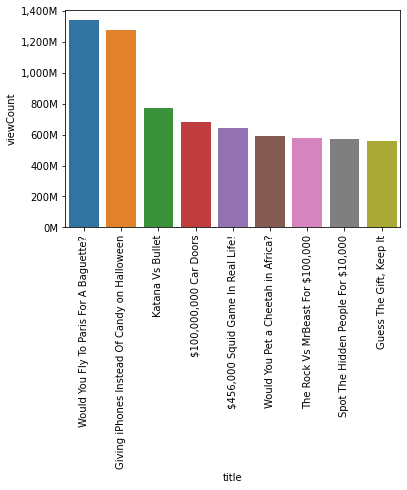

In [21]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000000) + 'M'))

## Worst performing videos

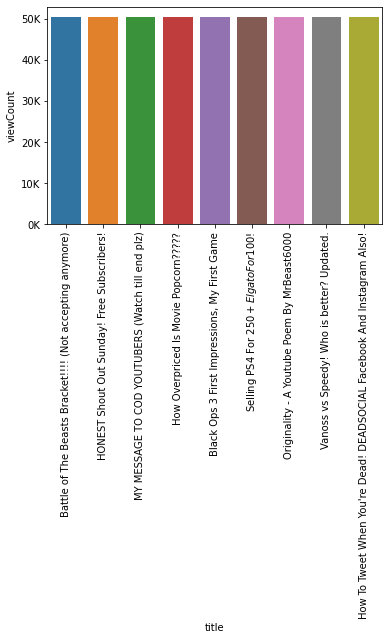

In [22]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=True)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

## View distribution per video

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='channelTitle', ylabel='viewCount'>

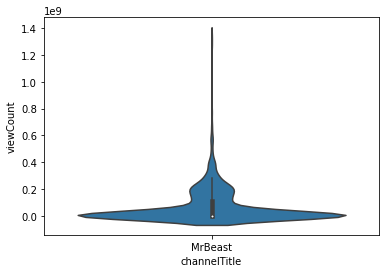

In [23]:
sns.violinplot(video_df['channelTitle'], video_df['viewCount'])

## Views vs. likes and comments

<AxesSubplot:xlabel='likeCount', ylabel='viewCount'>

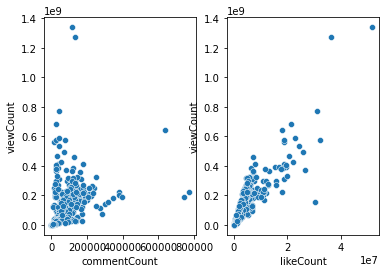

In [24]:
fig, ax = plt.subplots(1,2)
sns.scatterplot(data = video_df, x = 'commentCount', y = 'viewCount', ax = ax[0])
sns.scatterplot(data = video_df, x = 'likeCount', y = 'viewCount', ax = ax[1])

## Video duration

<AxesSubplot:xlabel='durationSecs', ylabel='Count'>

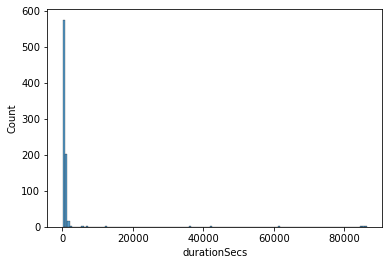

In [25]:
sns.histplot(data = video_df, x = 'durationSecs', bins=130)

## Wordcloud for video titles

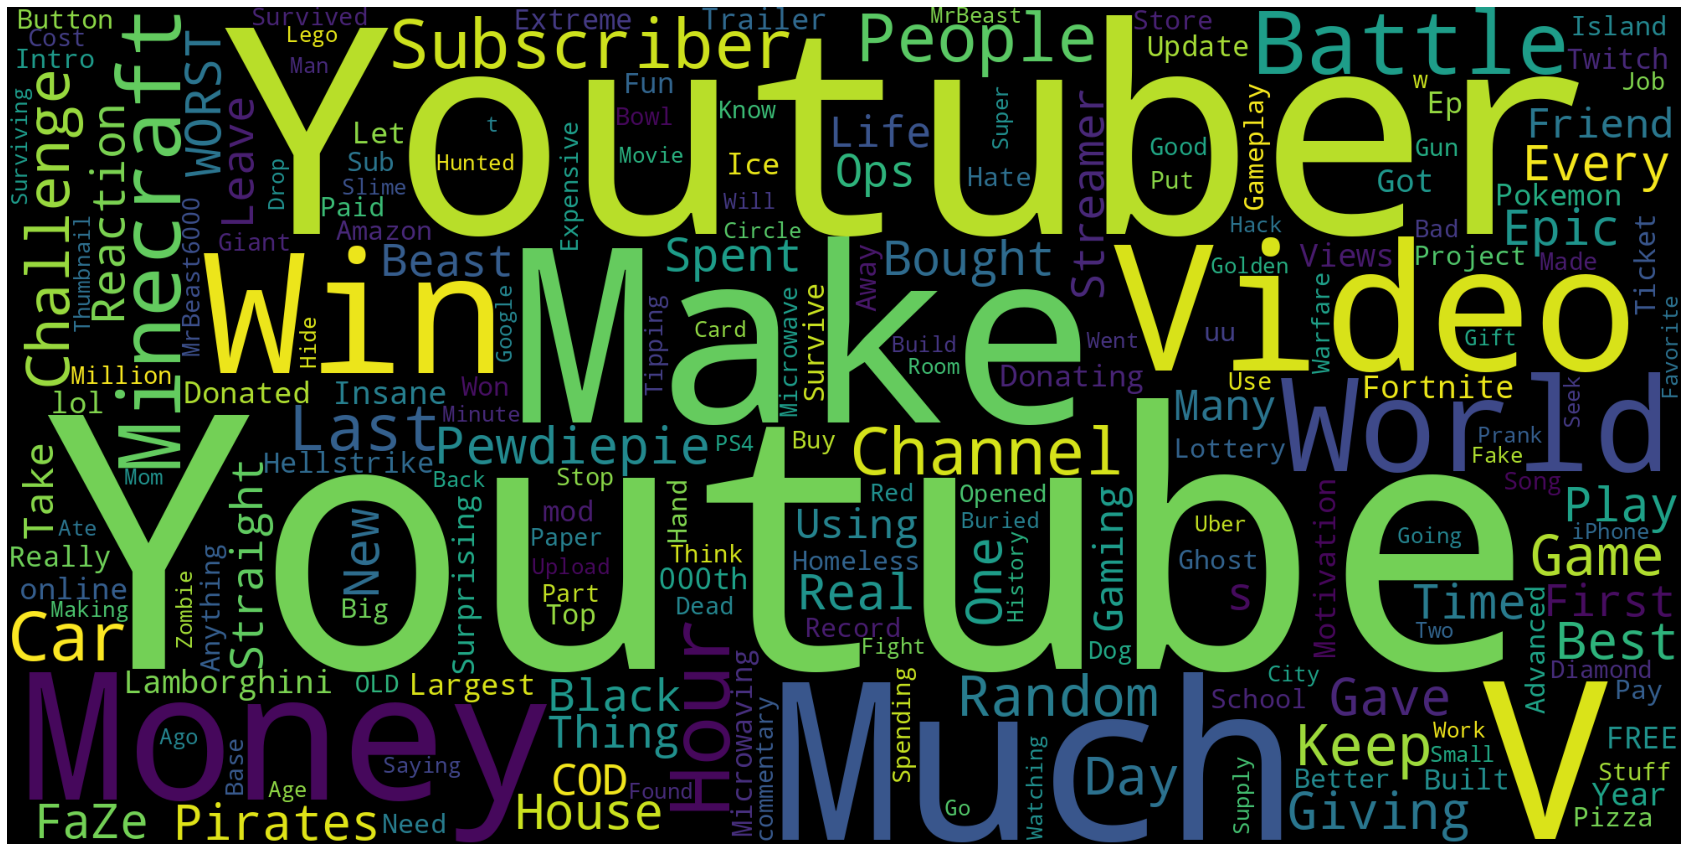

In [26]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                    colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

## Upload schedule

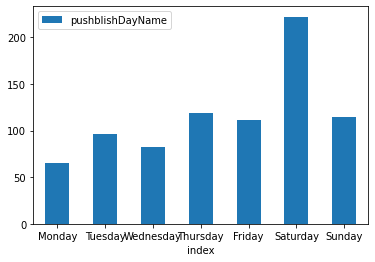

In [27]:
day_df = pd.DataFrame(video_df['pushblishDayName'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x='index', y='pushblishDayName', rot=0)